In [1]:
from model import *
from attention import pHLA_attns_draw_save
from mutation import *
from utils import Logger, cut_peptide_to_specific_length

In [2]:
import math
from sklearn import metrics
from sklearn import preprocessing
import numpy as np
import pandas as pd
import re
import time
import datetime
import random
random.seed(1234)
from scipy import interp
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from collections import OrderedDict
from functools import reduce
from tqdm import tqdm, trange
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import difflib

seed = 19961231
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

import os
os.chdir('./webserver/')
import argparse
import logging
import sys

In [3]:
parser = argparse.ArgumentParser(usage = 'peptide-HLA-I binding prediction')
parser.add_argument('--peptide_file', type = str, help = 'the path of the .fasta file contains peptides')
parser.add_argument('--HLA_file', type = str, help = 'the path of the .fasta file contains sequence')
parser.add_argument('--threshold', type = float, default = 0.5, help = 'the threshold to define predicted binder, float from 0 - 1, the recommended value is 0.5')
parser.add_argument('--cut_peptide', type = bool, default = False, help = 'Whether to split peptides larger than cut_length?')
parser.add_argument('--cut_length', type = int, default = 9, help = 'if there is a peptide sequence length > 15, we will segment the peptide according the length you choose, from 8 - 15')
parser.add_argument('--output_attention', type = bool, default = False, help = 'Output the mutual influence of peptide and HLA on the binding?')
parser.add_argument('--output_heatmap', type = bool, default = False, help = 'Visualize the mutual influence of peptide and HLA on the binding?')
parser.add_argument('--output_mutation', type = bool, default = True, help = 'Whether to perform mutations with better affinity for each sample?')
parser.add_argument('--output_dir', type = str, help = 'The directory where the output results are stored.')
args = parser.parse_args(args = [])
args

Namespace(HLA_file=None, cut_length=9, cut_peptide=True, output_attention=True, output_dir=None, output_heatmap=True, output_mutation=True, peptide_file=None, threshold=0.5)

In [4]:
args.peptide_file = 'peptides.fasta'
args.HLA_file = 'hlas.fasta'
args.output_dir = './results/'
if not os.path.exists(args.output_dir): os.makedirs(args.output_dir)

cut_length = args.cut_length

In [ ]:
if args.threshold <= 0 or args.threshold >= 1: 
    log = Logger('./error.log')
    log.logger.critical('The threshold invalid, please check whether it ranges from 0-1.')
    sys.exit(1)
if not args.peptide_file:
    log = Logger('./error.log')
    log.logger.critical('The peptide file is empty.')
    sys.exit(1)
if not args.HLA_file:
    log = Logger('./error.log')
    log.logger.critical('The HLA file is empty.')
    sys.exit(1)
if not args.output_dir:
    log = Logger('./error.log')
    log.logger.critical('Please fill the output file directory.')
    sys.exit(1)

# 读取文件

In [5]:
with open(args.peptide_file, 'r') as f:
    peptide_file = f.readlines()

with open(args.HLA_file, 'r') as f:
    HLA_file = f.readlines()
    
i = 0
ori_peptides, ori_HLA_names, ori_HLA_sequences = [], [], []
for pep, hla in zip(peptide_file, HLA_file):
    if i % 2 == 0:
        hla_name = hla.replace('>', '').replace('\t', '').replace('\n', '')
        ori_HLA_names.append(hla_name)
    if i % 2 == 1:
        hla_seq = str.upper(hla.replace('\n', '').replace('\t', ''))
        peptide = str.upper(pep.replace('\n', '').replace('\t', ''))
        ori_peptides.append(peptide)
        ori_HLA_sequences.append(hla_seq)
    i += 1

peptides, HLA_names, HLA_sequences = [], [], []
for pep, hla_name, hla_seq in zip(ori_peptides, ori_HLA_names, ori_HLA_sequences):
    
    if not (pep.isalpha() and hla.isalpha()): 
        continue
    if len(set(pep).difference(set('ARNDCQEGHILKMFPSTWYV'))) != 0:
        continue
    if len(set(hla_seq).difference(set('ARNDCQEGHILKMFPSTWYV'))) != 0:
        continue
            
    length = len(pep)
    if length < 15:
        if args.cut_peptide:
            if length > cut_length:
                cut_peptides = [pep] + [pep[i : i + cut_length] for i in range(length - cut_length + 1)]
                peptides.extend(cut_peptides)
                HLA_sequences.extend([hla_seq] * len(cut_peptides))
                HLA_names.extend([hla_name] * len(cut_peptides))
            else:
                peptides.append(pep)
                HLA_sequences.append(hla_seq)
                HLA_names.append(hla_name)
        else:
            peptides.append(pep)
            HLA_sequences.append(hla_seq)
            HLA_names.append(hla_name)
            
    else:
        cut_peptides = [pep[i : i + cut_length] for i in range(length - cut_length + 1)]
        peptides.extend(cut_peptides)
        HLA_sequences.extend([hla_seq] * len(cut_peptides))
        HLA_names.extend([hla_name] * len(cut_peptides))
        
predict_data = pd.DataFrame([HLA_names, HLA_sequences, peptides], index = ['HLA', 'HLA_sequence', 'peptide']).T
if predict_data.shape[0] == 0: 
    log = Logger('./error.log')
    log.logger.critical('No suitable data could be predicted. Please check your input data.')
    sys.exit(1)
    
if predict_data.shape[0] > 1000:
    args.output_heatmap = False
    args.output_mutation = False
    
    log = Logger('./error.log')
    log.logger.critical('Do not generate heatmap and mutation. Because the number of predict data > 50, and the output will be large.')
    sys.exit(1)
    
predict_data, predict_pep_inputs, predict_hla_inputs, predict_loader = read_predict_data(predict_data, batch_size)
predict_data

SystemExit: 1

# 预测

In [6]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

model_file = 'model_layer1_multihead9_fold4.pkl'

model_eval = Transformer().to(device)
model_eval.load_state_dict(torch.load(model_file), strict = True)

model_eval.eval()
y_pred, y_prob, attns = eval_step(model_eval, predict_loader, args.threshold, use_cuda)

predict_data['y_pred'], predict_data['y_prob'] = y_pred, y_prob
predict_data = predict_data.round({'y_prob': 4})

predict_data.to_csv(args.output_dir + '/predict_results.csv', index = False)
predict_data

100%|██████████| 1/1 [00:00<00:00, 35.11it/s]


,HLA,HLA_sequence,peptide,y_pred,y_prob
0,HLA-A*11:01,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,AEAFIQSA,0,0.0001
1,HLA-A*11:01,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,AEAFIQ,0,0.0008
2,HLA-A*11:01,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,AEAFIQPI,1,0.5539
3,HLA-A*68:01,YYAMYRNNVAQTDVDTLYIMYRDYTWAVWAYTWY,KVYEGVWKK,1,1.0000
4,HLA-A*68:01,YYAMYRNNVAQTDVDTLYIMYRDYTWAVWAYTWY,VYEGVWKKA,0,0.0000
5,HLA-A*68:01,YYAMYRNNVAQTDVDTLYIMYRDYTWAVWAYTWY,YEGVWKKAE,0,0.0000
6,HLA-A*68:01,YYAMYRNNVAQTDVDTLYIMYRDYTWAVWAYTWY,EGVWKKAEA,0,0.0000
7,HLA-A*68:01,YYAMYRNNVAQTDVDTLYIMYRDYTWAVWAYTWY,GVWKKAEAF,0,0.0000
8,HLA-A*68:01,YYAMYRNNVAQTDVDTLYIMYRDYTWAVWAYTWY,VWKKAEAFI,0,0.0000
9,HLA-A*68:01,YYAMYRNNVAQTDVDTLYIMYRDYTWAVWAYTWY,WKKAEAFIQ,0,0.0000


# 作图

100%|██████████| 9/9 [00:00<00:00, 3054.10it/s]


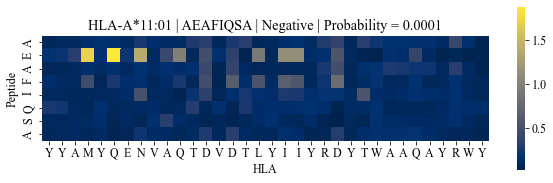

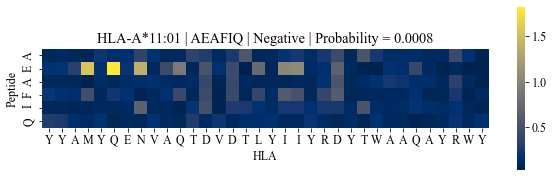

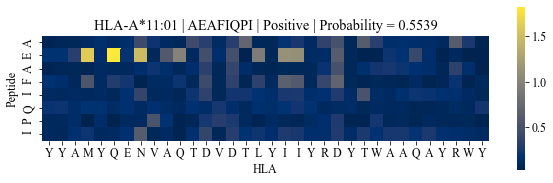

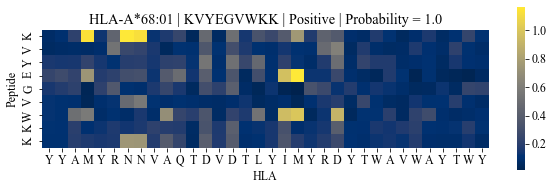

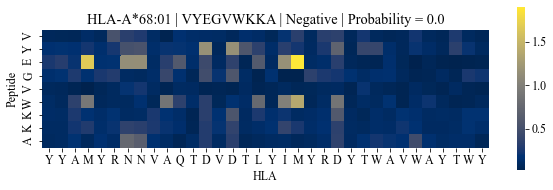

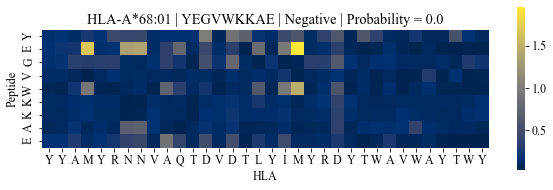

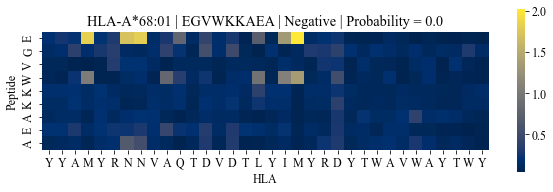

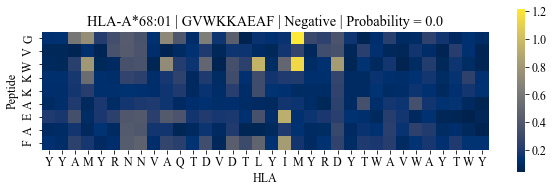

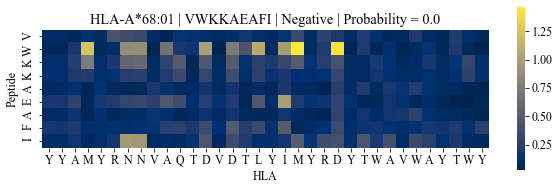

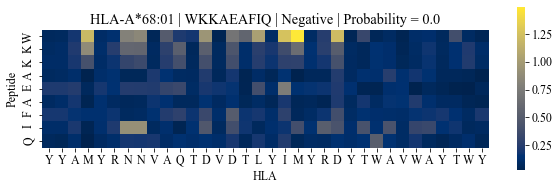

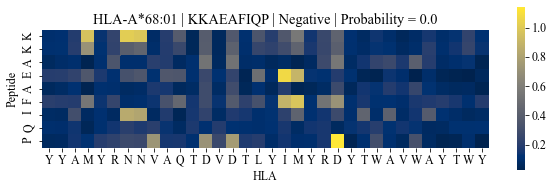

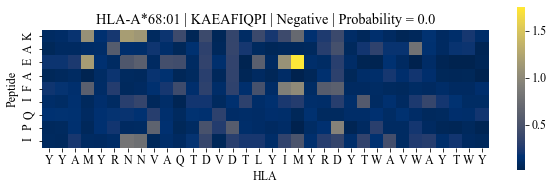

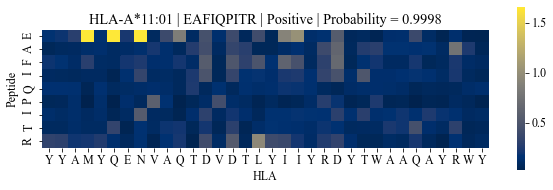

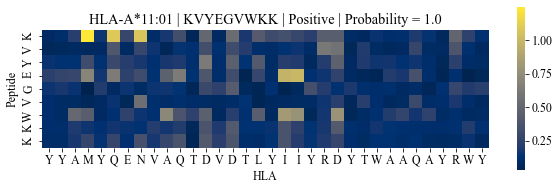

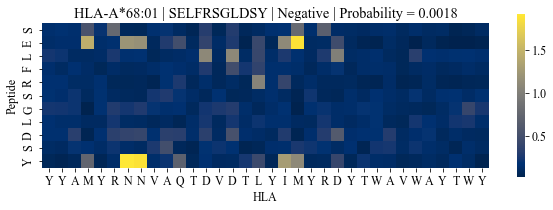

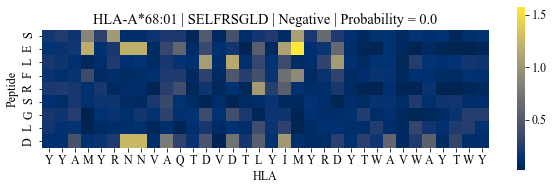

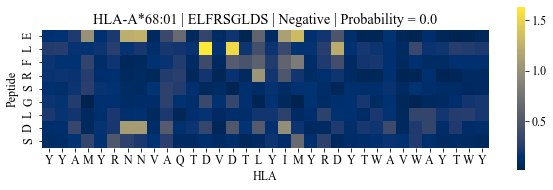

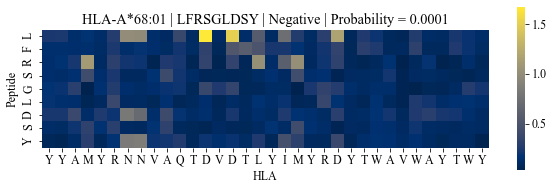

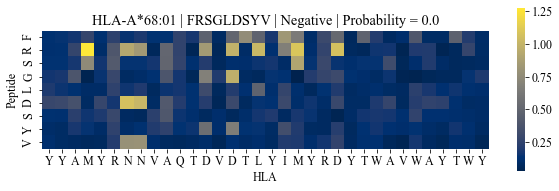

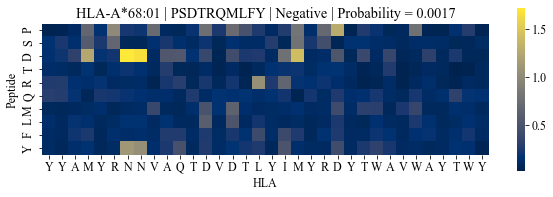

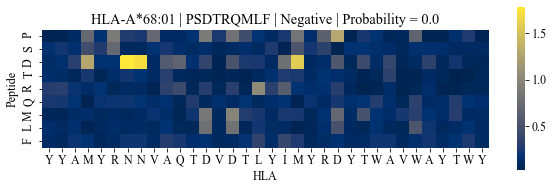

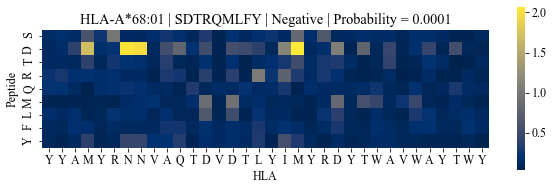

In [7]:
if args.output_attention or args.output_heatmap:
    
    if args.output_attention: 
        attn_savepath = args.output_dir + '/attention/'
        if not os.path.exists(attn_savepath):
            os.makedirs(attn_savepath)
    else:
        attn_savepath = False
    if args.output_heatmap: 
        fig_savepath = args.output_dir + '/figures/'
        if not os.path.exists(fig_savepath):
            os.makedirs(fig_savepath)
    else:
        fig_savepath = False
        
    for hla, pep in zip(predict_data.HLA, predict_data.peptide):
        pHLA_attns_draw_save(predict_data, attns, hla, pep, attn_savepath, fig_savepath)

# 突变

In [8]:
if args.output_mutation:
    
    mut_savepath = args.output_dir + '/mutation/'
    if not os.path.exists(mut_savepath):
        os.makedirs(mut_savepath)
    
    for idx in range(predict_data.shape[0]):
        peptide = predict_data.iloc[idx].peptide
        hla = predict_data.iloc[idx].HLA
        
        if len(peptide) < 8 or len(peptide) > 14: continue
            
        mut_peptides_df = pHLA_mutation_peptides(predict_data, attns, hla = hla, peptide = peptide)
        mut_data, _, _, mut_loader = read_predict_data(mut_peptides_df, batch_size)

        model_eval = Transformer().to(device)
        model_eval.load_state_dict(torch.load(model_file), strict = True)

        model_eval.eval()
        y_pred, y_prob, _ = eval_step(model_eval, mut_loader, args.threshold, use_cuda)

        mut_data['y_pred'], mut_data['y_prob'] = y_pred, y_prob
        mut_data = mut_data.round({'y_prob': 4})
        mut_data.to_csv(mut_savepath + '{}_{}_mutation.csv'.format(hla, peptide), index = False)
        print('********** {} | {} → # Mutation peptides = {}'.format(hla, peptide, mut_data.shape[0]-1))
        
        mut_peptides_IEDBfmt = ' '.join(mut_data.mutation_peptide)
        print('If you want to use IEDB tools to predict IC50, please use these format: \n {}'.format(mut_peptides_IEDBfmt))

  0%|          | 0/9 [00:00<?, ?it/s]

********** Strategy 1 **********
[2, 4, 1, 5, 3, 6, 8, 7] [3, 1, 2, 4, 5, 7, 6, 8]
Effect of 2E in Negative AEAFIQSA < Effect of 3['S', 'F', 'D', 'Y', 'I', 'N', 'Q', 'G', 'A'] in Positive HLA-A*11:01, Replace to 3['S', 'F', 'D']
['AESFIQSA', 'AEFFIQSA', 'AEDFIQSA']
Effect of 2E in Negative AEAFIQSA < Effect of 1['S', 'A', 'R', 'T', 'V', 'K', 'F'] in Positive HLA-A*11:01, Replace to 1['S', 'A', 'R']
['SESFIQSA', 'AESFIQSA', 'RESFIQSA']
['SEFFIQSA', 'AEFFIQSA', 'REFFIQSA']
['SEDFIQSA', 'AEDFIQSA', 'REDFIQSA']
Effect of 2E in Negative AEAFIQSA < Effect of 2['V', 'T', 'L', 'I', 'S', 'F'] in Positive HLA-A*11:01, Replace to 2['V', 'T', 'L']
['SVSFIQSA', 'STSFIQSA', 'SLSFIQSA']
['AVSFIQSA', 'ATSFIQSA', 'ALSFIQSA']
['RVSFIQSA', 'RTSFIQSA', 'RLSFIQSA']
['SVFFIQSA', 'STFFIQSA', 'SLFFIQSA']
['AVFFIQSA', 'ATFFIQSA', 'ALFFIQSA']
['RVFFIQSA', 'RTFFIQSA', 'RLFFIQSA']
['SVDFIQSA', 'STDFIQSA', 'SLDFIQSA']
['AVDFIQSA', 'ATDFIQSA', 'ALDFIQSA']
['RVDFIQSA', 'RTDFIQSA', 'RLDFIQSA']
Effect of 2E in Negativ

  0%|          | 0/9 [00:00<?, ?it/s]

********** Strategy 1 **********
[4, 2, 1, 5, 3, 8, 6, 7] [3, 1, 2, 4, 5, 7, 6, 8]
Effect of 4F in Negative AEAFIQPI < Effect of 3['S', 'F', 'D', 'Y', 'I', 'N', 'Q', 'G', 'A'] in Positive HLA-A*11:01, Replace to 3['S', 'F', 'D']
['AESFIQPI', 'AEFFIQPI', 'AEDFIQPI']
Effect of 4F in Negative AEAFIQPI < Effect of 1['S', 'A', 'R', 'T', 'V', 'K', 'F'] in Positive HLA-A*11:01, Replace to 1['S', 'A', 'R']
['SESFIQPI', 'AESFIQPI', 'RESFIQPI']
['SEFFIQPI', 'AEFFIQPI', 'REFFIQPI']
['SEDFIQPI', 'AEDFIQPI', 'REDFIQPI']
Effect of 4F in Negative AEAFIQPI < Effect of 2['V', 'T', 'L', 'I', 'S', 'F'] in Positive HLA-A*11:01, Replace to 2['V', 'T', 'L']
['SVSFIQPI', 'STSFIQPI', 'SLSFIQPI']
['AVSFIQPI', 'ATSFIQPI', 'ALSFIQPI']
['RVSFIQPI', 'RTSFIQPI', 'RLSFIQPI']
['SVFFIQPI', 'STFFIQPI', 'SLFFIQPI']
['AVFFIQPI', 'ATFFIQPI', 'ALFFIQPI']
['RVFFIQPI', 'RTFFIQPI', 'RLFFIQPI']
['SVDFIQPI', 'STDFIQPI', 'SLDFIQPI']
['AVDFIQPI', 'ATDFIQPI', 'ALDFIQPI']
['RVDFIQPI', 'RTDFIQPI', 'RLDFIQPI']
Effect of 4F in Negativ

100%|██████████| 9/9 [00:00<00:00, 560.98it/s]


********** Strategy 1 **********
[3, 2, 1, 8, 5, 4, 6, 7, 9] [1, 2, 3, 8, 4, 6, 5, 7, 9]
Effect of 3Y in Negative KVYEGVWKK < Effect of 1['E', 'D', 'S', 'T', 'A', 'N'] in Positive HLA-A*68:01, Replace to 1['E', 'D', 'S']
['EVYEGVWKK', 'DVYEGVWKK', 'SVYEGVWKK']
Effect of 3Y in Negative KVYEGVWKK < Effect of 2['T', 'V', 'A', 'S', 'I', 'L'] in Positive HLA-A*68:01, Replace to 2['T', 'V', 'A']
['ETYEGVWKK', 'EVYEGVWKK', 'EAYEGVWKK']
['DTYEGVWKK', 'DVYEGVWKK', 'DAYEGVWKK']
['STYEGVWKK', 'SVYEGVWKK', 'SAYEGVWKK']
Effect of 3Y in Negative KVYEGVWKK < Effect of 3['A', 'S', 'I', 'V', 'F', 'T'] in Positive HLA-A*68:01, Replace to 3['A', 'S', 'I']
['ETAEGVWKK', 'ETSEGVWKK', 'ETIEGVWKK']
['EVAEGVWKK', 'EVSEGVWKK', 'EVIEGVWKK']
['EAAEGVWKK', 'EASEGVWKK', 'EAIEGVWKK']
['DTAEGVWKK', 'DTSEGVWKK', 'DTIEGVWKK']
['DVAEGVWKK', 'DVSEGVWKK', 'DVIEGVWKK']
['DAAEGVWKK', 'DASEGVWKK', 'DAIEGVWKK']
['STAEGVWKK', 'STSEGVWKK', 'STIEGVWKK']
['SVAEGVWKK', 'SVSEGVWKK', 'SVIEGVWKK']
['SAAEGVWKK', 'SASEGVWKK', 'SAIEGVW

  0%|          | 0/1 [00:00<?, ?it/s]

********** HLA-A*68:01 | VYEGVWKKA → # Mutation peptides = 173
If you want to use IEDB tools to predict IC50, please use these format: 
 VYEGVWKKA VYEGVWKKR DYEGVWKKA VYEGVWKKK SYEGVWKKA EYEGVWKKA SVEGVWKKA DYEGVWKKR STEGVWKKA EAEGVWKKA ETEGVWKKA EYEGVWKKR DYEGVWKKK DVEGVWKKA EVEGVWKKA EYEGVWKKK DAEGVWKKA DTEGVWKKA SYEGVWKKK SAEGVWKKA SYEGVWKKR EAAGVWKKA STSGVWKKA STIGVWKKA DTIGVWKKA DAAGVWKKA ETEGVWKKR SAIGVWKKA SVAGVWKKA SVIGVWKKA EASGVWKKA ETEGVWKKK DTEGVWKKR DAEGVWKKR SVSGVWKKA STAGVWKKA SVEGVWKKR SAAGVWKKA STEGVWKKK ETIGVWKKA EVSGVWKKA DAEGVWKKK EAEGVWKKR DAIGVWKKA SAEGVWKKR SVEGVWKKK EAIGVWKKA SAEGVWKKK ETSGVWKKA STEGVWKKR EAEGVWKKK DVEGVWKKK DVIGVWKKA DVSGVWKKA EVEGVWKKK DVEGVWKKR DASGVWKKA DTSGVWKKA DTEGVWKKK ETAGVWKKA EVIGVWKKA SASGVWKKA EVAGVWKKA DVAGVWKKA DTAGVWKKA EVEGVWKKR STSGVWKKK EAIGVWKLA STSGVWKKR DTSGVWKLA DAIGVWKQA DAIGVWKLA EAAGVWKQA SAIGVWKKK EAIGVWKKK STAGVWKQA SVIGVWKQA DVSGVWKKR EASGVWKKK EAAGVWKKR DASGVWKKK STSGVWKLA EVAGVWKKR ETIGVWKKR DASGVWKQA SAAGVWKLA ETS

  0%|          | 0/1 [00:00<?, ?it/s]

********** HLA-A*68:01 | YEGVWKKAE → # Mutation peptides = 200
If you want to use IEDB tools to predict IC50, please use these format: 
 YEGVWKKAE YEGVWKKAK DEGVWKKAE YEGVWKKAR EEGVWKKAE SEGVWKKAE SAGVWKKAE EEGVWKKAK EAGVWKKAE SVGVWKKAE DVGVWKKAE SEGVWKKAK DTGVWKKAE DEGVWKKAR DEGVWKKAK EVGVWKKAE STGVWKKAE SEGVWKKAR DAGVWKKAE EEGVWKKAR ETGVWKKAE EVIVWKKAE DTGVWKKAR EASVWKKAE DTIVWKKAE STGVWKKAK EAGVWKKAK DVSVWKKAE ETGVWKKAK SVAVWKKAE EAAVWKKAE ETGVWKKAR SVSVWKKAE DAGVWKKAR EVGVWKKAK EVSVWKKAE DTSVWKKAE SVGVWKKAK DVGVWKKAR STAVWKKAE DAIVWKKAE DTAVWKKAE STSVWKKAE DASVWKKAE EVAVWKKAE DVIVWKKAE DAAVWKKAE DVAVWKKAE DTGVWKKAK STGVWKKAR SASVWKKAE EVGVWKKAR SAAVWKKAE STIVWKKAE SAGVWKKAR DAGVWKKAK EAGVWKKAR SVIVWKKAE SAGVWKKAK EAIVWKKAE ETAVWKKAE ETSVWKKAE SVGVWKKAR DVGVWKKAK SAIVWKKAE ETIVWKKAE DTAVWKKQE EVIVWKKLE ETAVWKKLE EVIVWKKQE STIVWKKKE DVIVWKKLE EVAVWKKLE DTAVWKKKE DVAVWKKAR DAIVWKKAK EVSVWKKKE DVIVWKKKE DTAVWKKLE ETSVWKKKE SAIVWKKKE EVSVWKKAK DASVWKKAK ETSVWKKAK ETAVWKKAR STSVWKKKE DTA

  0%|          | 0/1 [00:00<?, ?it/s]

********** HLA-A*68:01 | EGVWKKAEA → # Mutation peptides = 197
If you want to use IEDB tools to predict IC50, please use these format: 
 EGVWKKAEA SGVWKKAEA ETVWKKAEA EVVWKKAEA DGVWKKAEA EAVWKKAEA EGVWKKAER EGVWKKAEK DGVWKKAEK EASWKKAEA EAVWKKAEK ETVWKKAEK EVVWKKAEK EVAWKKAEA STVWKKAEA DAVWKKAEA ETVWKKAER SVVWKKAEA ETAWKKAEA ETIWKKAEA EVSWKKAEA SGVWKKAEK EAAWKKAEA EAVWKKAER EAIWKKAEA SGVWKKAER EVIWKKAEA SAVWKKAEA DTVWKKAEA DVVWKKAEA EVVWKKAER ETSWKKAEA DGVWKKAER EVSWKKAER STSWKKAEA EVAWKKAQA ETIWKKAEK EAIWKKAKA DAVWKKAER EVIWKKAQA STAWKKAEA DAVWKKAEK ETIWKKAQA ETSWKKAKA EASWKKALA DASWKKAEA DTVWKKAEK EAAWKKAKA ETSWKKAQA DVAWKKAEA EAIWKKAQA EVIWKKALA DVSWKKAEA ETIWKKAKA EAIWKKAEK DTAWKKAEA DAIWKKAEA EAIWKKAER EAIWKKALA EASWKKAEK EVAWKKAEK STVWKKAEK SVVWKKAEK ETSWKKAEK ETSWKKAER EVAWKKALA EVSWKKAEK SAAWKKAEA DAAWKKAEA ETAWKKAKA SAVWKKAEK ETAWKKALA EVAWKKAER EAAWKKAQA EVSWKKAKA EVSWKKALA SVAWKKAEA STVWKKAER SVSWKKAEA EVIWKKAKA EASWKKAKA ETSWKKALA STIWKKAEA EVIWKKAER EVSWKKAQA EASWKKAQA ETA

  0%|          | 0/1 [00:00<?, ?it/s]

********** HLA-A*68:01 | GVWKKAEAF → # Mutation peptides = 191
If you want to use IEDB tools to predict IC50, please use these format: 
 GVWKKAEAF DVWKKAEAF EVWKKAEAF GVWKKAEAR SVWKKAEAF GVWKKAEAK DVWKKAEAR DVIKKAEAF ETWKKAEAF SVAKKAEAF SVWKKAEAK DVSKKAEAF EVIKKAEAF DTWKKAEAF SVSKKAEAF EVWKKAEAK EAWKKAEAF DVAKKAEAF EVWKKAEAR STWKKAEAF SAWKKAEAF DVWKKAEAK SVWKKAEAR EVAKKAEAF SVIKKAEAF DAWKKAEAF EVSKKAEAF DVAKKAEKF EAAKKAEAF DTIKKAEAF SVAKKAEQF SVIKKAELF EVIKKAEKF SVSKKAEAR EVSKKAEQF ETAKKAEAF EASKKAEAF DAIKKAEAF EVAKKAELF STWKKAEAK SVIKKAEAK DVSKKAEAR SVSKKAEKF DVSKKAEKF STWKKAEAR DTSKKAEAF DVIKKAEKF EVIKKAEQF DVIKKAEQF SVAKKAEAR DAAKKAEAF EAIKKAEAF DVIKKAEAR EAWKKAEAR SAAKKAEAF STSKKAEAF DVIKKAELF SVIKKAEAR DTWKKAEAK SVAKKAEKF DTAKKAEAF DVSKKAELF EVAKKAEAK SAWKKAEAK SVSKKAEQF EVSKKAELF SVAKKAEAK SVAKKAELF EVIKKAEAK DVAKKAELF DAWKKAEAK STAKKAEAF DVIKKAEAK EVSKKAEAR EVSKKAEKF EVSKKAEAK DVAKKAEQF EVIKKAELF ETIKKAEAF DVSKKAEQF DVAKKAEAK SVSKKAELF EVIKKAEAR DTWKKAEAR SAIKKAEAF ETWKKAEAK SVI

  0%|          | 0/1 [00:00<?, ?it/s]

********** HLA-A*68:01 | VWKKAEAFI → # Mutation peptides = 200
If you want to use IEDB tools to predict IC50, please use these format: 
 VWKKAEAFI VWKKAEAFR VWKKAEAFK DWKKAEAFI EWKKAEAFI SWKKAEAFI DTKKAEAFI EWKKAEAFK EVKKAEAFI DWKKAEAFK DVKKAEAFI ETKKAEAFI DAKKAEAFI DWKKAEAFR STKKAEAFI EAKKAEAFI SWKKAEAFR SVKKAEAFI EWKKAEAFR SAKKAEAFI SWKKAEAFK SVKKAEAFR SAKKAEAFK SVSKAEAFI ETAKAEAFI DVKKAEAFR DVAKAEAFI SVKKAEAFK STKKAEAFR EASKAEAFI ETKKAEAFR DTIKAEAFI DVSKAEAFI EAKKAEAFR DTKKAEAFR ETIKAEAFI DTKKAEAFK STAKAEAFI EAAKAEAFI SVIKAEAFI SASKAEAFI DAKKAEAFK SAAKAEAFI SAKKAEAFR DVIKAEAFI DAKKAEAFR EVIKAEAFI STIKAEAFI ETSKAEAFI STKKAEAFK EAIKAEAFI ETKKAEAFK EVAKAEAFI DAIKAEAFI DASKAEAFI EVSKAEAFI DTAKAEAFI STSKAEAFI EVKKAEAFR EAKKAEAFK DVKKAEAFK SVAKAEAFI EVKKAEAFK DAAKAEAFI DTSKAEAFI SAIKAEAFI STIKAEAFK DTIKAEAKI DVAKAEAKI STAKAEAFK EASKAEAFR DASKAEALI SASKAEAKI DTSKAEAFK EASKAEALI DASKAEAFK DTAKAEAFK ETSKAEALI SVSKAEAFR SAAKAEAFR DAAKAEAKI STIKAEAKI STSKAEALI DAAKAEAQI SVAKAEAFK ETSKAEAFK EVI

100%|██████████| 1/1 [00:00<00:00, 39.83it/s]


********** HLA-A*68:01 | WKKAEAFIQ → # Mutation peptides = 200
If you want to use IEDB tools to predict IC50, please use these format: 
 WKKAEAFIQ SKKAEAFIQ WKKAEAFIK DKKAEAFIQ EKKAEAFIQ WKKAEAFIR SKKAEAFIR SAKAEAFIQ DKKAEAFIR DTKAEAFIQ DKKAEAFIK EAKAEAFIQ SKKAEAFIK EKKAEAFIK ETKAEAFIQ DVKAEAFIQ EKKAEAFIR STKAEAFIQ SVKAEAFIQ DAKAEAFIQ EVKAEAFIQ SAKAEAFIR DTSAEAFIQ EVSAEAFIQ DVIAEAFIQ DTAAEAFIQ SVSAEAFIQ ETKAEAFIK STKAEAFIR DAIAEAFIQ EVKAEAFIK STAAEAFIQ ETKAEAFIR STSAEAFIQ EVKAEAFIR DVAAEAFIQ ETSAEAFIQ DVKAEAFIR DAAAEAFIQ ETAAEAFIQ EASAEAFIQ SAIAEAFIQ DAKAEAFIK DAKAEAFIR DTKAEAFIK DTIAEAFIQ EAKAEAFIR DVKAEAFIK SVAAEAFIQ STIAEAFIQ DVSAEAFIQ SVKAEAFIK SVIAEAFIQ SVKAEAFIR SAKAEAFIK SASAEAFIQ DTKAEAFIR EVIAEAFIQ SAAAEAFIQ STKAEAFIK EVAAEAFIQ DASAEAFIQ ETIAEAFIQ EAIAEAFIQ EAAAEAFIQ EAKAEAFIK EASAEAFQQ SVSAEAFIR DTAAEAFLQ DAAAEAFQQ EVIAEAFKQ ETAAEAFIK EAIAEAFIR SVSAEAFIK SVIAEAFQQ EVSAEAFQQ EVIAEAFLQ DAIAEAFLQ DVIAEAFIR STAAEAFKQ DASAEAFQQ DVAAEAFKQ EASAEAFKQ STSAEAFIK SAAAEAFIK DASAEAFIR DTA

100%|██████████| 1/1 [00:00<00:00, 34.39it/s]


********** HLA-A*68:01 | KKAEAFIQP → # Mutation peptides = 146
If you want to use IEDB tools to predict IC50, please use these format: 
 KKAEAFIQP KKAEAFIQK EKAEAFIQP SKAEAFIQP DKAEAFIQP KKAEAFIQR SVAEAFIQP ETAEAFIQP EKAEAFIQK EKAEAFIQR EAAEAFIQP DTAEAFIQP SKAEAFIQK DVAEAFIQP EVAEAFIQP DKAEAFIQR DKAEAFIQK SKAEAFIQR DAAEAFIQP SAAEAFIQP STAEAFIQP SVAEAFILP DAIEAFIQP STAEAFIQR SAAEAFIKP STAEAFIQK DVSEAFIQP EAIEAFIQP STAEAFIKP ETAEAFIQK DVAEAFIQK ETAEAFILP STSEAFIQP DVAEAFIKP SVAEAFIKP EAAEAFIQR EVSEAFIQP DAAEAFIQR ETAEAFIQR EAAEAFILP EVAEAFIKP ETSEAFIQP ETAEAFIKP SAAEAFILP DTAEAFIQK SVAEAFIQK SASEAFIQP DTAEAFILP EAAEAFIQK EASEAFIQP EAAEAFIKP SVIEAFIQP EVAEAFIQK DVIEAFIQP SVSEAFIQP DAAEAFIKP SAAEAFIQR DTIEAFIQP DTSEAFIQP STIEAFIQP DASEAFIQP SAAEAFIQK EVAEAFIQR DVAEAFILP EVAEAFILP SVAEAFIQR DAAEAFILP DVAEAFIQR STAEAFILP ETIEAFIQP EVIEAFIQP DTAEAFIKP SAIEAFIQP DAAEAFIQK DTAEAFIQR ETSEAFIQK ETSEAFIQR DAIEAFILP SVIEAFIQR DVSEAFIKP STIEAFIQR DVIEAFIQR DVSEAFIQK EVSEAFIQK SAIEAFIQR EAIEAFILP EAS

  0%|          | 0/1 [00:00<?, ?it/s]

********** HLA-A*68:01 | KAEAFIQPI → # Mutation peptides = 191
If you want to use IEDB tools to predict IC50, please use these format: 
 KAEAFIQPI KAEAFIQPR EAEAFIQPI KAEAFIQPK SAEAFIQPI DAEAFIQPI DAEAFIQPR SAEAFIQPR SAEAFIQPK SASAFIQPI EAIAFIQPI DAIAFIQPI EASAFIQPI DASAFIQPI DAEAFIQPK EAEAFIQPK DTEAFIQPI DVEAFIQPI DAAAFIQPI SVEAFIQPI EVEAFIQPI SAAAFIQPI ETEAFIQPI EAEAFIQPR EAAAFIQPI STEAFIQPI SAIAFIQPI EAIAFIQKI SAIAFIQQI DAIAFIQKI SAAAFIQQI ETAAFIQPI DAIAFIQQI EVEAFIQPR EASAFIQPR DVIAFIQPI DAAAFIQQI SAAAFIQPK SAIAFIQPR EAAAFIQPK SAAAFIQPR EAIAFIQPR STSAFIQPI EASAFIQPK STEAFIQPK EAAAFIQPR DTEAFIQPK DAIAFIQPR EAIAFIQLI DASAFIQLI DASAFIQPK DAIAFIQLI EASAFIQKI SAIAFIQPK ETSAFIQPI ETEAFIQPR EASAFIQLI DVEAFIQPR STIAFIQPI DASAFIQQI SAIAFIQKI DVEAFIQPK EAAAFIQKI DTEAFIQPR EVAAFIQPI DVSAFIQPI DTAAFIQPI DAAAFIQLI SVEAFIQPR SAAAFIQLI DVAAFIQPI EAIAFIQPK ETIAFIQPI SVEAFIQPK DTSAFIQPI EAAAFIQLI SASAFIQPK EVIAFIQPI SVAAFIQPI SASAFIQQI EAIAFIQQI DAAAFIQPR DTIAFIQPI EAAAFIQQI DASAFIQPR EVEAFIQPK EVS

100%|██████████| 1/1 [00:00<00:00, 34.46it/s]

********** HLA-A*11:01 | EAFIQPITR → # Mutation peptides = 155
If you want to use IEDB tools to predict IC50, please use these format: 
 EAFIQPITR RAFIQPITR EAFIQPITY SAFIQPITR ETFIQPITR EVFIQPITR EAFIQPITK ESFIQPITR AAFIQPITR SVFIQPITR RTFIQPITR SSFIQPITR SAFIQPITK RAFIQPITY RAFIQPITK ETFIQPITK ETFIQPITY EVFIQPITK ASFIQPITR RVFIQPITR AVFIQPITR ESFIQPITY RSFIQPITR EVFIQPITY SAFIQPITY STFIQPITR ATFIQPITR AAFIQPITK ESFIQPITK AAFIQPITY SVFIQPITY SSFIQPITY ASAIQPITR SSLIQPITR AVAIQPITR RVLIQPITR RVFIQPITK RVAIQPITR RSFIQPVTR SVLIQPITR RVFIQPLTR AVFIQPITY STFIQPVTR STFIQPITY AVFIQPVTR SSAIQPITR SVFIQPVTR STAIQPITR RTFIQPITY ASFIQPVTR ASFIQPITK SVFIQPITK ATFIQPVTR SVAIQPITR ASFIQPLTR AVFIQPLTR ATAIQPITR ASFIQPITY SVFIQPLTR ASLIQPITR SSFIQPITK ATLIQPITR SSFIQPVTR RTLIQPITR AVLIQPITR RTFIQPLTR SSFIQPLTR RTFIQPVTR RSAIQPITR RSFIQPLTR AVFIQPITK ATFIQPLTR RVFIQPVTR RTFIQPITK STFIQPLTR RSFIQPITK RTAIQPITR RSLIQPITR ATFIQPITY RSFIQPITY STLIQPITR RVFIQPITY ATFIQPITK STFIQPITK STFIQPLTY SVFIQPLTY RVF


100%|██████████| 9/9 [00:00<00:00, 261.43it/s]


********** HLA-A*11:01 | KVYEGVWKK → # Mutation peptides = 197
If you want to use IEDB tools to predict IC50, please use these format: 
 KVYEGVWKK RVYEGVWKK KTYEGVWKK KVYEGVWKR KSYEGVWKK AVYEGVWKK KVYEGVWKY SVYEGVWKK AVYEGVLKK SVYEGVVKK SVFEGVWKK ASYEGVWKK AVFEGVWKK AVYEGVVKK SVAEGVWKK SSYEGVWKK SVYEGVIKK RVLEGVWKK AVLEGVWKK KTYEGVWKR AVYEGVWKY SVYEGVWKY STYEGVWKK RSYEGVWKK ATYEGVWKK RVYEGVLKK RVAEGVWKK RVFEGVWKK KSYEGVWKY SVYEGVWKR RVYEGVIKK RVYEGVWKY KSYEGVWKR AVAEGVWKK AVYEGVWKR AVYEGVIKK SVYEGVLKK RTYEGVWKK SVLEGVWKK RVYEGVWKR KTYEGVWKY RVYEGVVKK RVFEGVWKR RVYEGVVKR STYEGVWKR SVFEGVWKY RSFEGVWKK ATLEGVWKK AVYEGVIKY RVYEGVIKY SSLEGVWKK ATFEGVWKK RSAEGVWKK ASFEGVWKK ASYEGVWKR SVYEGVLKR RVLEGVWKR AVAEGVWKR SSYEGVIKK RSYEGVWKR RTFEGVWKK ASLEGVWKK RTYEGVIKK RVAEGVWKR SVYEGVVKR SVYEGVVKY SVYEGVLKY AVFEGVWKY AVYEGVVKR SVYEGVIKR ASYEGVLKK ASYEGVIKK RVYEGVIKR SVLEGVWKR ATYEGVIKK AVAEGVWKY RSYEGVIKK SSAEGVWKK AVYEGVVKY SSFEGVWKK SSYEGVVKK SSYEGVLKK SVYEGVIKY RTYEGVLKK ATYEGVWKR STYEGVIKK AVL

  0%|          | 0/1 [00:00<?, ?it/s]

********** HLA-A*68:01 | SELFRSGLDSY → # Mutation peptides = 275
If you want to use IEDB tools to predict IC50, please use these format: 
 SELFRSGLDSY SELGRSGLDSY SALFRSGLDSY EELFRSGLDSY DELFRSGLDSY SELSRSGLDSY SVLFRSGLDSY STLFRSGLDSY SELDRSGLDSY EALFRSGLDSY SVLFRSGLVSY SELSRSGLDSK STLSRSGLDSY SVLGRSGLDSY ETLFRSGLDSY STLFRSGLISY SELDRSGLDSK SALSRSGLDSY SVLSRSGLDSY SVLDRSGLDSY SELGRSGLDSR SALGRSGLDSY DVLFRSGLDSY SELDRSGLDSR EVLFRSGLDSY STLFRSGLLSY SALFRSGLVSY DALFRSGLDSY STLGRSGLDSY STLFRSGLVSY SALDRSGLDSY SALFRSGLLSY SELSRSGLDSR SELGRSGLDSK SALFRSGLISY SVLFRSGLISY SVLFRSGLLSY STLDRSGLDSY DTLFRSGLDSY DALGRSGLDSY SVLDRSGLDSR STLDRSVLDSY DTLFRSGLLSY STLDRSGLDSK SALGRSGLLSY SVLDRSGLDSK STLDRSGLVSY SALGRSVLDSY DTLGRSGLDSY EVLDRSGLDSY STLSRSGLDSK STLSRSGLLSY DTLFRSGLISY DELDRSGLDSK SVLGRSGLDSK DVLFRSGLLSY STLGRSSLDSY EALSRSGLDSY SVLGRSVLDSY STLDRSSLDSY DTLFRSGLVSY SVLGRSGLDSR STLGRSVLDSY SVLSRSGLISY SALSRSGLDSR SVLDRSGLVSY DELGRSGLDSK STLSRSGLISY SVLDRSSLDSY EALDRSGLDSY STLSRSSLDSY SALGRSGLD

  0%|          | 0/1 [00:00<?, ?it/s]

********** HLA-A*68:01 | SELFRSGLD → # Mutation peptides = 170
If you want to use IEDB tools to predict IC50, please use these format: 
 SELFRSGLD EELFRSGLD STLFRSGLD SELFRSGLR DELFRSGLD SALFRSGLD SVLFRSGLD SELFRSGLK SALFRSGLK DELFRSGLR SAIFRSGLD DVLFRSGLD EELFRSGLR SAAFRSGLD STLFRSGLR SASFRSGLD EALFRSGLD SVLFRSGLR STIFRSGLD DELFRSGLK STAFRSGLD STLFRSGLK ETLFRSGLD SALFRSGLR SVSFRSGLD DALFRSGLD SVAFRSGLD EELFRSGLK STSFRSGLD DTLFRSGLD SVIFRSGLD EVLFRSGLD SVLFRSGLK SASFRSGLR EVLFRSGLR SVAFRSGQD EASFRSGLD SVIFRSGQD SASFRSGLK SASFRSGQD DTLFRSGLR STSFRSGLR DVSFRSGLD DTIFRSGLD DAIFRSGLD DTLFRSGLK SVAFRSGLK STAFRSGLK STIFRSGLK SASFRSGKD STSFRSGKD EAAFRSGLD DAAFRSGLD SAAFRSGLR SVAFRSGLR STAFRSGQD STIFRSGQD EALFRSGLK SAIFRSGLK STIFRSGKD SVIFRSGKD ETSFRSGLD ETLFRSGLK SVIFRSGLK ETAFRSGLD ETLFRSGLR SVAFRSGKD DVIFRSGLD DASFRSGLD EVSFRSGLD STAFRSGKD DALFRSGLR SVSFRSGKD DTSFRSGLD SVSFRSGLR SAAFRSGKD STSFRSGLK EVLFRSGLK ETIFRSGLD DALFRSGLK DVLFRSGLK DVLFRSGLR SVSFRSGQD STSFRSGQD SAAFRSGQD EVAFRSGLD SVS

100%|██████████| 9/9 [00:00<00:00, 224.03it/s]


********** HLA-A*68:01 | ELFRSGLDS → # Mutation peptides = 197
If you want to use IEDB tools to predict IC50, please use these format: 
 ELFRSGLDS DLFRSGLDS ELFRSGLDK ELFRSGLDR SLFRSGLDS EAFRSGLDS EVFRSGLDS ETFRSGLDS DLFRSGLDR SAFRSGLDS EAFRSGLDR EVFRSGLDR EVARSGLDS ETSRSGLDS EAIRSGLDS EASRSGLDS EVFRSGLDK ETIRSGLDS ETFRSGLDK ETARSGLDS SLFRSGLDK DLFRSGLDK ETFRSGLDR EAFRSGLDK EVSRSGLDS SVFRSGLDS DTFRSGLDS EVIRSGLDS STFRSGLDS DAFRSGLDS EAARSGLDS DVFRSGLDS SLFRSGLDR ETARSGLLS SVARSGLDS EVARSGLDK SVFRSGLDK EVARSGLDR ETARSGLDK DTSRSGLDS EAARSGLLS SVIRSGLDS EVSRSGLQS EAIRSGLKS ETIRSGLLS ETARSGLDR SAIRSGLDS EVARSGLLS EAARSGLDK DAIRSGLDS EASRSGLDR DVARSGLDS EVSRSGLDK EASRSGLLS DAFRSGLDK EASRSGLDK STFRSGLDR ETSRSGLDK DTFRSGLDR STARSGLDS ETARSGLKS EAIRSGLDR ETSRSGLLS EASRSGLQS SAARSGLDS ETIRSGLDK EVIRSGLQS STFRSGLDK DASRSGLDS ETIRSGLKS EAIRSGLQS EVARSGLKS DAARSGLDS EVSRSGLDR DTARSGLDS EAARSGLQS EAARSGLDR EVSRSGLLS SASRSGLDS DVFRSGLDK DTIRSGLDS ETIRSGLDR STIRSGLDS EVIRSGLKS STSRSGLDS ETSRSGLDR EVA

  0%|          | 0/1 [00:00<?, ?it/s]

********** HLA-A*68:01 | LFRSGLDSY → # Mutation peptides = 200
If you want to use IEDB tools to predict IC50, please use these format: 
 LFRSGLDSY DFRSGLDSY EFRSGLDSY SFRSGLDSY LFRSGLDSR LFRSGLDSK DTRSGLDSY EVRSGLDSY EFRSGLDSK EFRSGLDSR DVRSGLDSY STRSGLDSY SFRSGLDSR SARSGLDSY SVRSGLDSY DFRSGLDSR DFRSGLDSK DARSGLDSY SFRSGLDSK EARSGLDSY ETRSGLDSY SVRSGLDSK SVISGLDSY STSSGLDSY EAASGLDSY EVRSGLDSK DTRSGLDSR ETSSGLDSY SARSGLDSK EARSGLDSK DTISGLDSY DAISGLDSY DVISGLDSY SVSSGLDSY EVISGLDSY STRSGLDSK EARSGLDSR DASSGLDSY SARSGLDSR ETASGLDSY EVRSGLDSR DVRSGLDSK SAASGLDSY EVASGLDSY DTRSGLDSK SAISGLDSY DARSGLDSK ETRSGLDSK DVASGLDSY STISGLDSY DVSSGLDSY EAISGLDSY SVRSGLDSR STRSGLDSR DTASGLDSY SASSGLDSY STASGLDSY EVSSGLDSY ETRSGLDSR DARSGLDSR ETISGLDSY DAASGLDSY SVASGLDSY DVRSGLDSR EASSGLDSY DTSSGLDSY ETSSGLDSK EASSGLDLY DAISGLDKY DTSSGLDSR DTASGLDSK EASSGLDQY SVISGLDSR SAASGLDQY DVSSGLDLY EVASGLDSR DVASGLDKY STISGLDSR EVISGLDLY STISGLDLY DASSGLDKY EVISGLDQY ETISGLDSR SVSSGLDLY EVASGLDKY SVASGLDSK SAI

100%|██████████| 9/9 [00:00<00:00, 292.04it/s]


********** HLA-A*68:01 | FRSGLDSYV → # Mutation peptides = 191
If you want to use IEDB tools to predict IC50, please use these format: 
 FRSGLDSYV FRSGLDSYR FRIGLDSYV DRSGLDSYV ERSGLDSYV FRAGLDSYV FRSGLDSYK SRSGLDSYV ERSGLDSYK DRSGLDSYR EVSGLDSYV SVSGLDSYV EASGLDSYV FRAGLDSYR DTSGLDSYV DASGLDSYV FRAGLDSYK ERSGLDSYR STSGLDSYV DRSGLDSYK SRSGLDSYK ETSGLDSYV SASGLDSYV SRSGLDSYR DVSGLDSYV FRIGLDSYK FRIGLDSYR STSGLDSLV SVSGLDSLV SRIGLDSYR ETSGLDSYR STIGLDSYV DASGLDSKV DTIGLDSYV DRAGLDSYK DTSGLDSKV EASGLDSYK STSGLDSYR DTAGLDSYV EAIGLDSYV DTSGLDSYR ETSGLDSKV STSGLDSKV EASGLDSQV SVAGLDSYV SASGLDSLV DASGLDSLV DAAGLDSYV EVSGLDSYK DASGLDSYK ETSGLDSYK DVSGLDSLV ETSGLDSQV SVSGLDSYK SVIGLDSYV DTSGLDSQV EVAGLDSYV DRIGLDSYR DASGLDSYR EASGLDSKV ERAGLDSYR EVSGLDSQV EAAGLDSYV SAAGLDSYV ERIGLDSYK SRAGLDSYR SVSGLDSKV DTSGLDSLV STSGLDSQV SASGLDSYK ETAGLDSYV EVSGLDSYR DVSGLDSKV SRIGLDSYK ETIGLDSYV SVSGLDSQV SRAGLDSYK DVAGLDSYV DTSGLDSYK EASGLDSYR ETSGLDSLV DVSGLDSQV EVIGLDSYV EASGLDSLV EVSGLDSLV DAIGLDSYV SAS

100%|██████████| 9/9 [00:00<00:00, 173.46it/s]


********** HLA-A*68:01 | PSDTRQMLFY → # Mutation peptides = 296
If you want to use IEDB tools to predict IC50, please use these format: 
 PSDTRQMLFY PSDTVQMLFY SSDTRQMLFY PTDTRQMLFY PSDTRQMIFY PSDTRQMLFR PSDTIQMLFY PVDTRQMLFY PSDTLQMLFY DSDTRQMLFY ESDTRQMLFY PSDTRQMLFK PSDTRQMVFY SSDTRQMLTY DVDTRQMLFY SSFTRQMLFY SSITRQMLFY PVDTVQMLFY ESATRQMLFY EVDTRQMLFY ESDTRQMLLY PSDTLQMLFK DSITRQMLFY DTDTRQMLFY ESDTRQMLTY PTDTVQMLFY SSDTRQMLFR STDTRQMLFY SSDTRQMIFY PSDTRQMIFR ESDTRQMIFY SVDTRQMLFY ESDTRQMLFK PSDTLQMLFR ETDTRQMLFY PSDTIQMIFY DSDTRQMVFY DSDTRQMLLY PVDTRQMLFK PVDTRQMVFY PSDTRQMVFK PVDTLQMLFY DSFTRQMLFY PTDTRQMLFK PVDTRQMIFY PSDTVQMLFR SSDTRQMLLY PTDTIQMLFY ESFTRQMLFY PSDTRQMVFR PTDTLQMLFY PTDTRQMVFY PSDTVQMIFY PSDTVQMVFY SSDTRQMLNY PSDTLQMVFY DSDTRQMIFY PVDTRQMLFR SSDTRQMVFY ESDTRQMLNY PTDTRQMLFR PTDTRQMIFY PSDTLQMIFY PVDTIQMLFY PSDTVQMLFK DSATRQMLFY SSDTRQMLFK PSDTIQMVFY DSDTRQMLFR PSDTIQMLFR DSDTRQMLFK ESDTRQMLFR DSDTRQMLTY PSDTIQMLFK ESITRQMLFY DSDTRQMLNY SSATRQMLFY PSDTRQMIFK ESDT

  0%|          | 0/1 [00:00<?, ?it/s]

********** HLA-A*68:01 | PSDTRQMLF → # Mutation peptides = 200
If you want to use IEDB tools to predict IC50, please use these format: 
 PSDTRQMLF PSSTRQMLF PSITRQMLF ESDTRQMLF DSDTRQMLF SSDTRQMLF PSATRQMLF PSDTRQMLK PSDTRQMLR SVDTRQMLF STDTRQMLF DTDTRQMLF PSATRQMLK ETDTRQMLF EADTRQMLF PSITRQMLR SSDTRQMLR DADTRQMLF ESDTRQMLK DSDTRQMLK DVDTRQMLF SADTRQMLF SSDTRQMLK ESDTRQMLR PSATRQMLR EVDTRQMLF PSSTRQMLR PSITRQMLK PSSTRQMLK DSDTRQMLR SVATRQMLF DSATRQMLR EADTRQMLR EAITRQMLF SSITRQMLR EADTRQMLK DVDTRQMLK DADTRQMLR DADTRQMLK DAATRQMLF DTDTRQMLR EVDTRQMLR ETDTRQMLR SSATRQMLR DVDTRQMLR DSATRQMLK SAATRQMLF EVSTRQMLF ESSTRQMLK SSSTRQMLR ESITRQMLK DSITRQMLK DSSTRQMLK DTITRQMLF ESATRQMLK STATRQMLF DVSTRQMLF DAITRQMLF SASTRQMLF ETDTRQMLK ESSTRQMLR STDTRQMLK DSSTRQMLR DTSTRQMLF SSATRQMLK ETITRQMLF DASTRQMLF ESITRQMLR EVITRQMLF ETATRQMLF STSTRQMLF DTATRQMLF SAITRQMLF SVDTRQMLK DTDTRQMLK ETSTRQMLF SVDTRQMLR DVATRQMLF DSITRQMLR STDTRQMLR SVSTRQMLF EVATRQMLF EVDTRQMLK SADTRQMLK ESATRQMLR SSITRQMLK EAA

100%|██████████| 1/1 [00:00<00:00, 31.74it/s]

********** HLA-A*68:01 | SDTRQMLFY → # Mutation peptides = 218
If you want to use IEDB tools to predict IC50, please use these format: 
 SDTRQMLFY SDIRQMLFY EDTRQMLFY SDARQMLFY SDSRQMLFY SDTRQMLFR STTRQMLFY SATRQMLFY DDTRQMLFY SVTRQMLFY SDTRQMLFK DVTRQMLFY STIRQMLFY SAARQMLFY SDSRQMLFR DDTRQMLFR EVTRQMLFY SDARQMLFR ETTRQMLFY SDARQMLFK SAIRQMLFY SVTRQMLFR SASRQMLFY SVIRQMLFY EDTRQMLFR SATRQMLFR EATRQMLFY SDIRQMLFR STARQMLFY EDTRQMLFK STSRQMLFY STTRQMLFK SDIRQMLFK DTTRQMLFY DDTRQMLFK STTRQMLFR SVARQMLFY SVSRQMLFY SDSRQMLFK DATRQMLFY SATRQMLFK SVTRQMLFK SAARQMLLY STIRQMLQY STARQMLLY STIRQMLLY SVARQMLFR EASRQMLFY SVARQMLKY SASRQMLFK EVSRQMLFY SVSRQMLLY SVIRQMLFK DTARQMLFY SVIRQMLFR DDSRQMLFR ETSRQMLFY ETARQMLFY SVIRQMLKY DTTRQMLFK SAIRQMLFK STARQMLQY STSRQMLLY SASRQMLFR SASRQMLQY DDIRQMLFK DAARQMLFY DVTRQMLFR SAIRQMLLY SAARQMLKY EATRQMLFR SVIRQMLQY DTTRQMLFR EDSRQMLFR EDSRQMLFK ETTRQMLFK EVTRQMLFR EVIRQMLFY ETTRQMLFR SVARQMLQY SASRQMLLY SVIRQMLLY EDIRQMLFR EDARQMLFK SAIRQMLFR SVSRQMLQY SAI

# 压缩文件

In [12]:
# mut_mb = 25/1024
# fig_mb = 2
# attn_mb = 10/1024
# (mut_mb + fig_mb + attn_mb)*2000 

In [2]:
from utils import make_zip
make_zip(source_dir = '/home/chujunyi/5_ZY_MHC/webserver', output_filename = '/home/chujunyi/5_ZY_MHC/webserver.zip')

In [10]:
# make_zip(source_dir = args.output_dir, output_filename = './results.zip')
# import shutil
# shutil.rmtree(args.output_dir)